# 여드름 종류 진단 AI

### 라이브러리 Import

In [11]:
import numpy as np
import pandas as pd
import os
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

### 설정 및 경로 지정

In [2]:
# 라벨 정의 (순서대로 정상, 좁쌀, 화농성, 염증성, 모낭염)
labels = ['normal', 'comedones', 'pustules', 'papules', 'folliculitis']

# 데이터 경로
data_dir = '/Users/jeongjin/Desktop/Git/AcneLog_AI/data'

# 이미지 크기
image_size = (224, 224)

# 하이퍼파라미터
BATCH_SIZE = 32
EPOCHS_PHASE1 = 10
EPOCHS_PHASE2 = 10
INITIAL_LR = 0.001
FINE_TUNE_LR = 1e-5

labels

['normal', 'comedones', 'pustules', 'papules', 'folliculitis']

### 데이터 로드 및 전처리

In [4]:
def load_images_and_labels(data_dir, labels, image_size=(224, 224)):
    """
    이미지 데이터를 로드하고 전처리하는 함수
    
    Args:
        data_dir: 데이터 디렉토리 경로
        labels: 클래스 라벨 리스트
        image_size: 리사이즈할 이미지 크기
    
    Returns:
        images: numpy array of images
        targets: numpy array of labels
    """
    image_dir = os.path.join(data_dir, 'image')
    images, targets = [], []
    
    for idx, label in enumerate(labels):
        folder_path = os.path.join(image_dir, label)
        print(f"Loading {label}...", end=' ')
        
        file_count = 0
        for file in os.listdir(folder_path):
            if not file.lower().endswith(('.jpg', '.jpeg', '.png')):
                continue
            
            img_path = os.path.join(folder_path, file)
            img = cv2.imread(img_path)
            
            if img is None:
                print(f"\n  Warning: Failed to load {img_path}")
                continue
            
            # BGR to RGB 변환
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # 리사이즈
            img = cv2.resize(img, image_size)
            # 정규화 [0, 1]
            img = img / 255.0
            
            images.append(img)
            targets.append(idx)
            file_count += 1
        
        print(f"→ {file_count} images loaded")
    
    return np.array(images, dtype=np.float32), np.array(targets)

### 데이터 로드 및 확인

In [5]:
# 데이터 로드
X, y = load_images_and_labels(data_dir, labels, image_size)

print(f"\n{'='*50}")
print(f"전체 데이터: {len(X)} images")
print(f"이미지 shape: {X.shape}")
print(f"\n클래스별 분포:")
for idx, label in enumerate(labels):
    count = np.sum(y == idx)
    print(f"  {label}: {count} images ({count/len(y)*100:.1f}%)")
print(f"{'='*50}")

Loading normal... → 27 images loaded
Loading comedones... → 14 images loaded
Loading pustules... → 11 images loaded
Loading papules... → 12 images loaded
Loading folliculitis... → 12 images loaded

전체 데이터: 76 images
이미지 shape: (76, 224, 224, 3)

클래스별 분포:
  normal: 27 images (35.5%)
  comedones: 14 images (18.4%)
  pustules: 11 images (14.5%)
  papules: 12 images (15.8%)
  folliculitis: 12 images (15.8%)


### 샘플 이미지 시각화

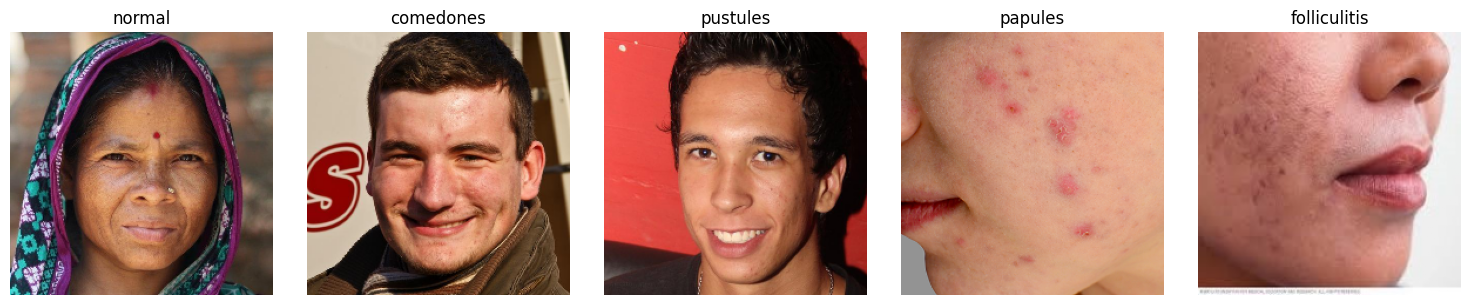

In [6]:
# 각 클래스별로 샘플 이미지 표시
plt.figure(figsize=(15, 3))
for idx, label in enumerate(labels):
    # 해당 클래스의 첫 번째 이미지 찾기
    sample_idx = np.where(y == idx)[0][0]
    plt.subplot(1, 5, idx + 1)
    plt.imshow(X[sample_idx])
    plt.title(f"{label}")
    plt.axis('off')
plt.tight_layout()
plt.show()

### Train/Validation 분할

In [12]:
# Train/Val 분할 (80:20)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y, 
    random_state=42
)

print(f"학습 데이터: {len(X_train)} images")
print(f"검증 데이터: {len(X_val)} images")

# One-hot encoding
num_classes = len(labels)
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes=num_classes)

print(f"\nOne-hot encoded shape:")
print(f"  y_train: {y_train_cat.shape}")
print(f"  y_val: {y_val_cat.shape}")

학습 데이터: 60 images
검증 데이터: 16 images

One-hot encoded shape:
  y_train: (60, 5)
  y_val: (16, 5)


### 데이터 증강 (Data Augmentation)

In [13]:
# 데이터 증강 (보수적으로)
datagen = ImageDataGenerator(
    rotation_range=15,           # 회전 각도
    width_shift_range=0.1,       # 가로 이동
    height_shift_range=0.1,      # 세로 이동
    horizontal_flip=True,        # 좌우 반전
    zoom_range=0.1,              # 줌
    fill_mode='nearest'          # 빈 공간 채우기
)

print("데이터 증강 설정 완료")

데이터 증강 설정 완료


### 모델 구성

In [14]:
# EfficientNetB0 base model
base_model = EfficientNetB0(
    weights='imagenet', 
    include_top=False, 
    input_shape=(224, 224, 3)
)

# Transfer Learning: 처음엔 base model 동결
base_model.trainable = False

# Custom head 추가
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(num_classes, activation='softmax')(x)  # ✅ 5개 클래스

# 최종 모델
model = Model(inputs=base_model.input, outputs=outputs)

print("모델 구축 완료")
print(f"\n출력 레이어: {num_classes} classes")
print(f"Base model layers: {len(base_model.layers)}")
print(f"Total model layers: {len(model.layers)}")

모델 구축 완료

출력 레이어: 5 classes
Base model layers: 238
Total model layers: 244


In [15]:
model.summary() # 모델 구조 확인

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_4         │ (None, 224, 224,  │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_2     │ (None, 224, 224,  │          7 │ rescaling_4[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_5         │ (None, 224, 224,  │          0 │ normalization_2[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_5[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,411,048 (16.83 MB)

 Trainable params: 361,477 (1.38 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

### 모델 학습 Phase1: Head 학습 (Base Model 동결)

In [16]:
# 컴파일
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
callbacks_phase1 = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]

print("=" * 60)
print("Phase 1: Training head only (base model frozen)")
print("=" * 60)

history1 = model.fit(
    datagen.flow(X_train, y_train_cat, batch_size=BATCH_SIZE),
    validation_data=(X_val, y_val_cat),
    epochs=EPOCHS_PHASE1,
    callbacks=callbacks_phase1,
    verbose=1
)

Phase 1: Training head only (base model frozen)


/Users/jeongjin/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.1929 - loss: 1.6205 - val_accuracy: 0.3750 - val_loss: 1.5384 - learning_rate: 0.0010
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 409ms/step - accuracy: 0.2595 - loss: 1.6045 - val_accuracy: 0.3750 - val_loss: 1.5201 - learning_rate: 0.0010
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 387ms/step - accuracy: 0.3806 - loss: 1.6102 - val_accuracy: 0.3750 - val_loss: 1.5190 - learning_rate: 0.0010
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.3472 - loss: 1.6190 - val_accuracy: 0.3750 - val_loss: 1.5208 - learning_rate: 0.0010
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 387ms/step - accuracy: 0.3183 - loss: 1.5577 - val_accuracy: 0.3750 - val_loss: 1.5310 - learning_rate: 0.0010
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.2688 - loss: 1.5870
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 419ms/step - accuracy: 0.2958 - loss: 1.5742 - val_accuracy: 0.37

### Phase 1 결과 시각화

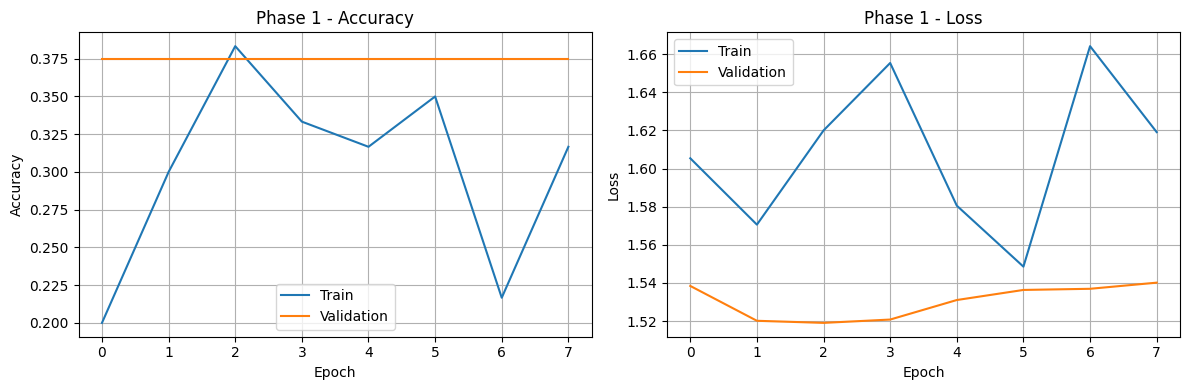


Phase 1 Best Validation Accuracy: 0.3750


In [17]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'], label='Train')
plt.plot(history1.history['val_accuracy'], label='Validation')
plt.title('Phase 1 - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history1.history['loss'], label='Train')
plt.plot(history1.history['val_loss'], label='Validation')
plt.title('Phase 1 - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 최고 성능 출력
best_val_acc_phase1 = max(history1.history['val_accuracy'])
print(f"\nPhase 1 Best Validation Accuracy: {best_val_acc_phase1:.4f}")

### 모델 학습 Phase 2: Fine-tuning

In [18]:
# Base model의 일부 레이어만 학습 가능하게 설정
base_model.trainable = True

# 마지막 30%만 학습
fine_tune_at = int(len(base_model.layers) * 0.7)

print(f"Total base model layers: {len(base_model.layers)}")
print(f"Freezing layers: 0 - {fine_tune_at-1}")
print(f"Training layers: {fine_tune_at} - {len(base_model.layers)-1}")

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# 낮은 learning rate로 재컴파일
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=FINE_TUNE_LR),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\nModel recompiled for fine-tuning")

Total base model layers: 238
Freezing layers: 0 - 165
Training layers: 166 - 237

Model recompiled for fine-tuning


In [19]:
callbacks_phase2 = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-8,
        verbose=1
    )
]

print("=" * 60)
print("Phase 2: Fine-tuning (last 30% layers unfrozen)")
print("=" * 60)

history2 = model.fit(
    datagen.flow(X_train, y_train_cat, batch_size=BATCH_SIZE),
    validation_data=(X_val, y_val_cat),
    epochs=EPOCHS_PHASE2,
    callbacks=callbacks_phase2,
    verbose=1
)

Phase 2: Fine-tuning (last 30% layers unfrozen)
Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.2056 - loss: 1.7795 - val_accuracy: 0.3750 - val_loss: 1.5190 - learning_rate: 1.0000e-05
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step - accuracy: 0.1929 - loss: 1.7574 - val_accuracy: 0.3750 - val_loss: 1.5190 - learning_rate: 1.0000e-05
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step - accuracy: 0.1468 - loss: 1.6822 - val_accuracy: 0.3750 - val_loss: 1.5190 - learning_rate: 1.0000e-05
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.1619 - loss: 1.7434
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step - accuracy: 0.1802 - loss: 1.7316 - val_accuracy: 0.3750 - val_loss: 1.5190 - learning_rate: 1.0000e-05
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 476ms/step - accuracy: 0.2181 - loss: 1.7186 - val_accuracy: 0.3750 - val_loss: 1.5190 - learning_rate: 5.0000e-06
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 

### Phase 2 결과 시각화

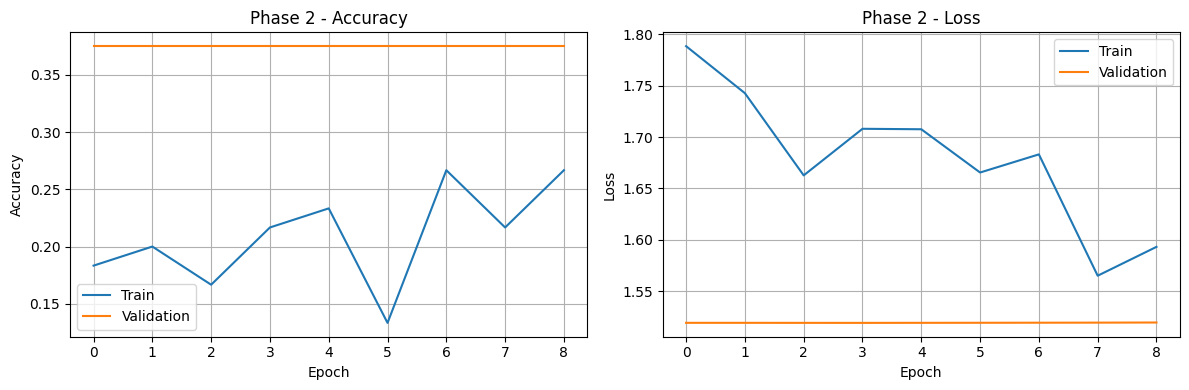


Phase 2 Best Validation Accuracy: 0.3750


In [20]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'], label='Train')
plt.plot(history2.history['val_accuracy'], label='Validation')
plt.title('Phase 2 - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], label='Train')
plt.plot(history2.history['val_loss'], label='Validation')
plt.title('Phase 2 - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

best_val_acc_phase2 = max(history2.history['val_accuracy'])
print(f"\nPhase 2 Best Validation Accuracy: {best_val_acc_phase2:.4f}")

### 전체 학습 과정 시각화

학습 곡선 저장: training_curves.png


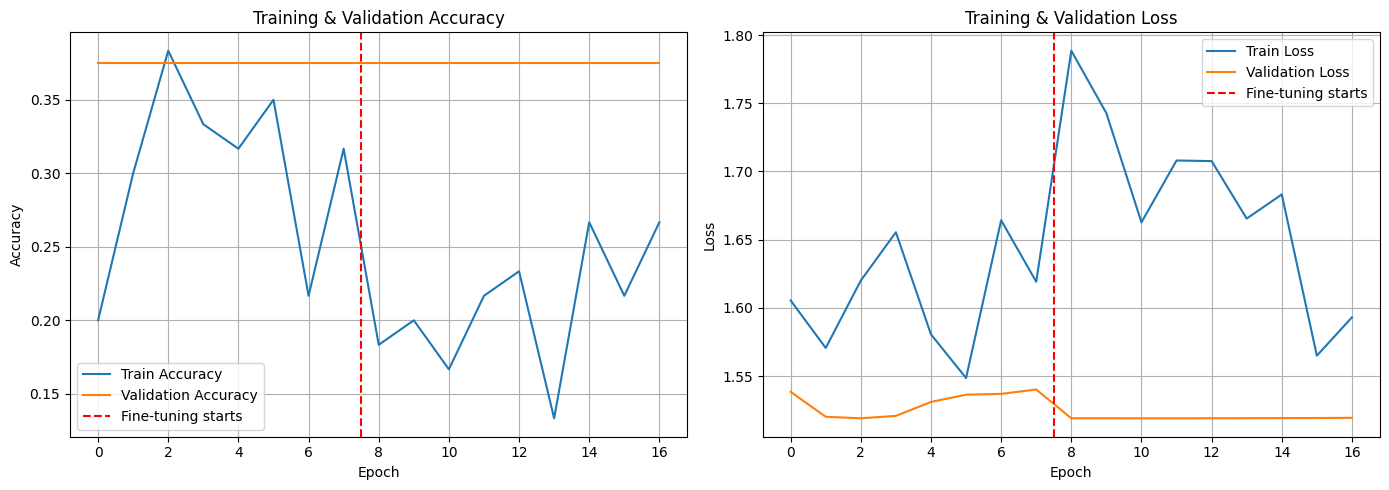

In [21]:
# 두 phase 합치기
acc = history1.history['accuracy'] + history2.history['accuracy']
val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']
loss = history1.history['loss'] + history2.history['loss']
val_loss = history1.history['val_loss'] + history2.history['val_loss']

epochs_range = range(len(acc))
phase1_end = len(history1.history['accuracy'])

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.axvline(x=phase1_end-0.5, color='r', linestyle='--', label='Fine-tuning starts')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.axvline(x=phase1_end-0.5, color='r', linestyle='--', label='Fine-tuning starts')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=150, bbox_inches='tight')
print("학습 곡선 저장: training_curves.png")
plt.show()

### 모델 평가

In [22]:
# 최종 평가
val_loss, val_acc = model.evaluate(X_val, y_val_cat, verbose=0)

print("=" * 60)
print("최종 평가 결과")
print("=" * 60)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print("=" * 60)

최종 평가 결과
Validation Loss: 1.5190
Validation Accuracy: 0.3750


### 예측 및 Classification Report

In [23]:
# 예측
y_pred = model.predict(X_val, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val_cat, axis=1)

# Classification Report
print("\nClassification Report:")
print("=" * 60)
print(classification_report(y_true_classes, y_pred_classes, target_names=labels))


Classification Report:
              precision    recall  f1-score   support

      normal       0.38      1.00      0.55         6
   comedones       0.00      0.00      0.00         3
    pustules       0.00      0.00      0.00         2
     papules       0.00      0.00      0.00         3
folliculitis       0.00      0.00      0.00         2

    accuracy                           0.38        16
   macro avg       0.07      0.20      0.11        16
weighted avg       0.14      0.38      0.20        16



/Users/jeongjin/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeongjin/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeongjin/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

### Confusion Matrix 시각화

Confusion Matrix 저장: confusion_matrix.png


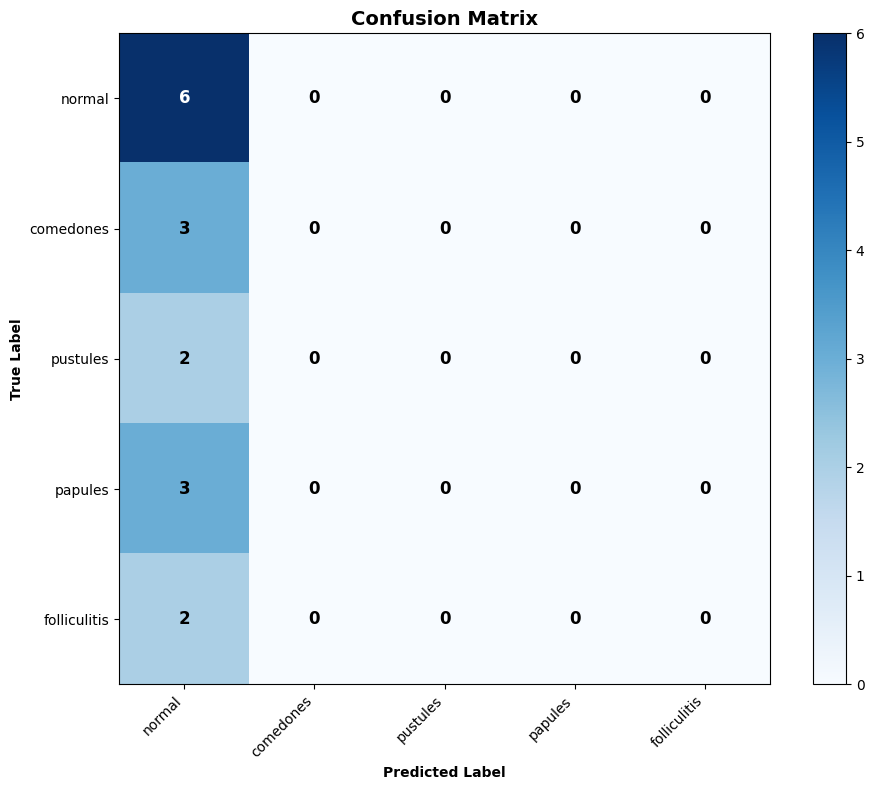

In [24]:
# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.colorbar()

tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45, ha='right')
plt.yticks(tick_marks, labels)

# 숫자 표시
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black",
                fontsize=12, fontweight='bold')

plt.ylabel('True Label', fontweight='bold')
plt.xlabel('Predicted Label', fontweight='bold')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
print("Confusion Matrix 저장: confusion_matrix.png")
plt.show()

### 클래스별 정확도 분석


클래스별 정확도:
normal         : 1.0000 (100.00%)
comedones      : 0.0000 (0.00%)
pustules       : 0.0000 (0.00%)
papules        : 0.0000 (0.00%)
folliculitis   : 0.0000 (0.00%)

클래스별 정확도 그래프 저장: class_accuracy.png


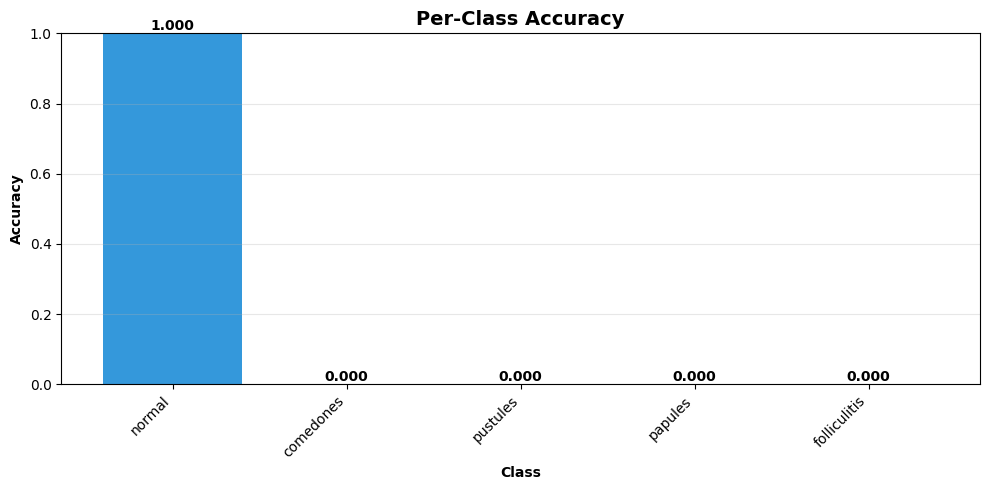

In [25]:
# 클래스별 정확도
class_accuracy = cm.diagonal() / cm.sum(axis=1)

print("\n클래스별 정확도:")
print("=" * 60)
for label, acc in zip(labels, class_accuracy):
    print(f"{label:15s}: {acc:.4f} ({acc*100:.2f}%)")
print("=" * 60)

# 시각화
plt.figure(figsize=(10, 5))
bars = plt.bar(labels, class_accuracy, color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6'])
plt.title('Per-Class Accuracy', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy', fontweight='bold')
plt.xlabel('Class', fontweight='bold')
plt.ylim([0, 1])
plt.grid(axis='y', alpha=0.3)

# 막대 위에 수치 표시
for bar, acc in zip(bars, class_accuracy):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{acc:.3f}',
            ha='center', va='bottom', fontweight='bold')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('class_accuracy.png', dpi=150, bbox_inches='tight')
print("\n클래스별 정확도 그래프 저장: class_accuracy.png")
plt.show()

### 예측 샘플 시각화

예측 샘플 저장: prediction_samples.png


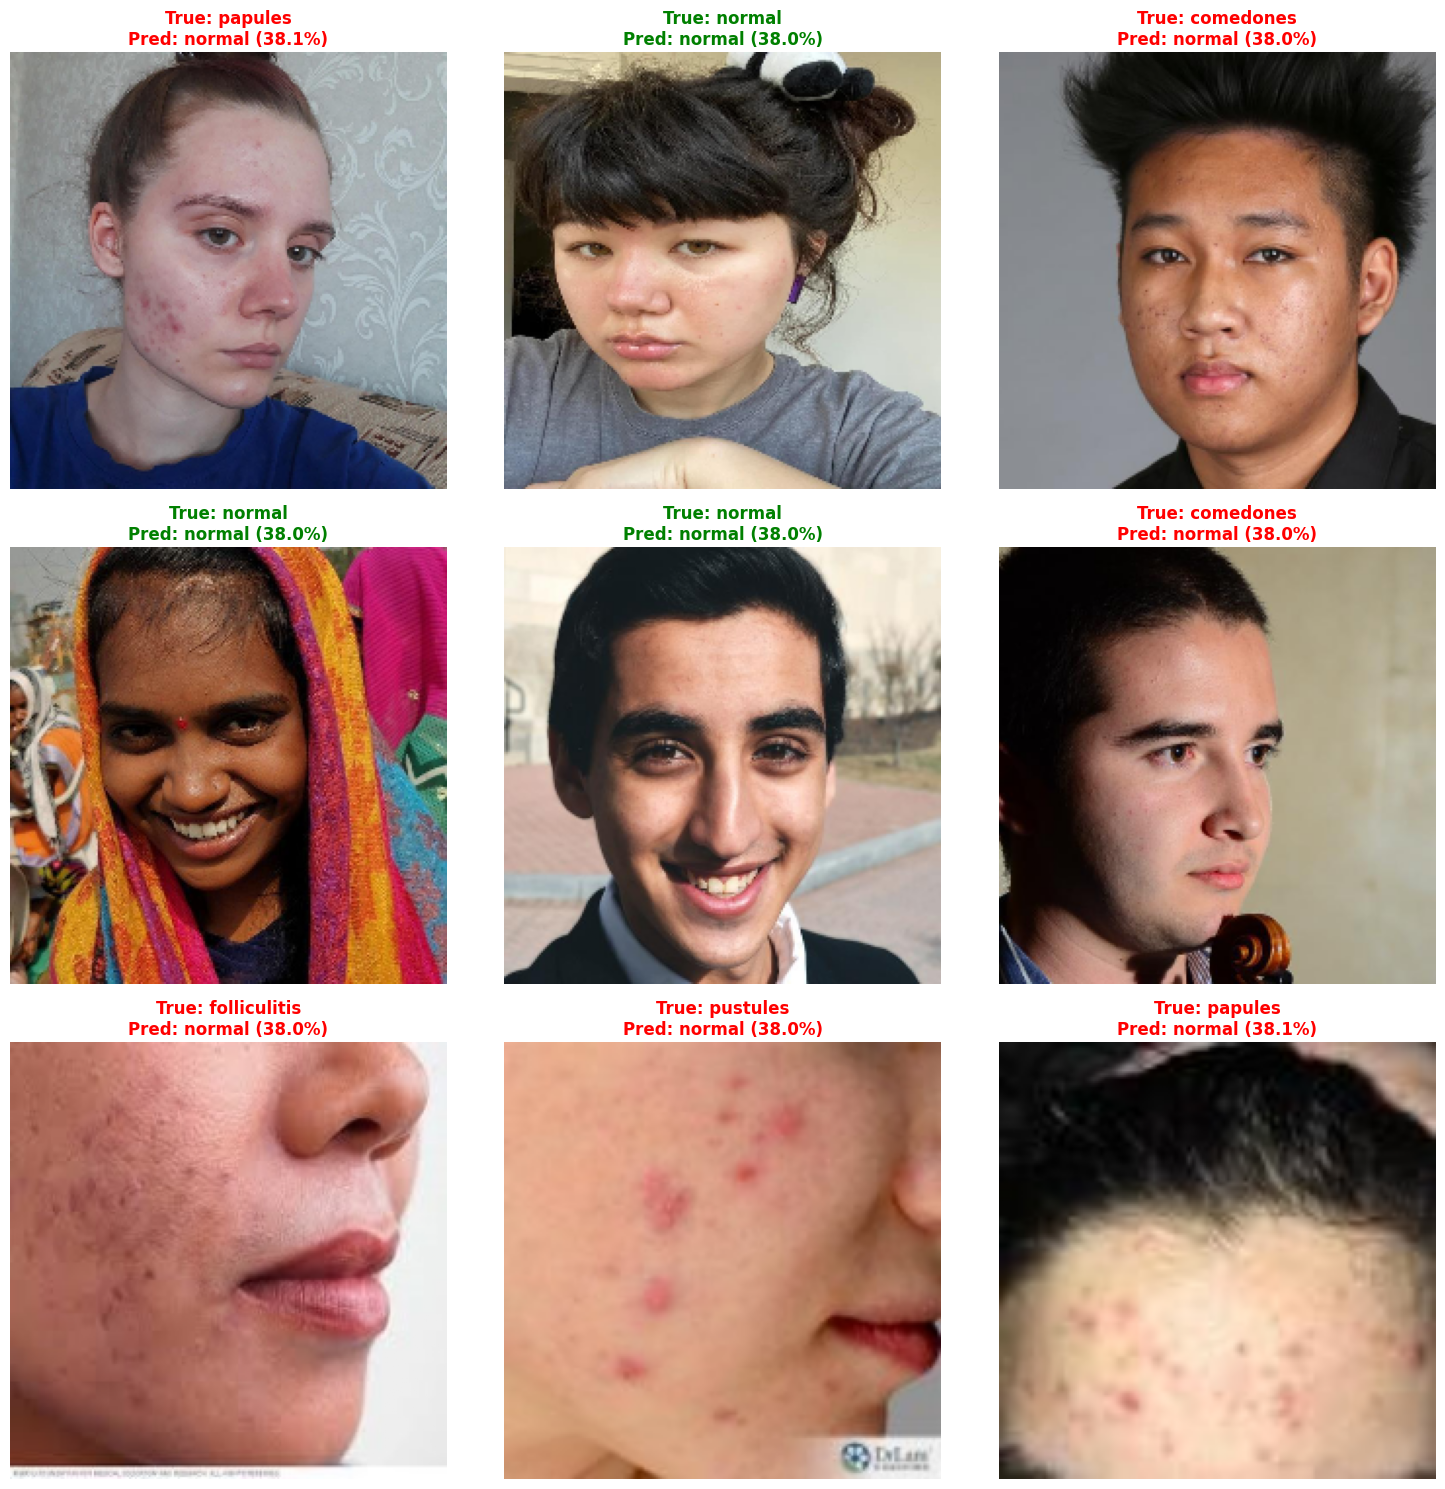

In [26]:
# 랜덤으로 9개 샘플 선택
sample_indices = np.random.choice(len(X_val), 9, replace=False)

plt.figure(figsize=(15, 15))
for i, idx in enumerate(sample_indices):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_val[idx])
    
    true_label = labels[y_true_classes[idx]]
    pred_label = labels[y_pred_classes[idx]]
    confidence = y_pred[idx][y_pred_classes[idx]] * 100
    
    color = 'green' if true_label == pred_label else 'red'
    plt.title(f"True: {true_label}\nPred: {pred_label} ({confidence:.1f}%)",
             color=color, fontweight='bold')
    plt.axis('off')

plt.tight_layout()
plt.savefig('prediction_samples.png', dpi=150, bbox_inches='tight')
print("예측 샘플 저장: prediction_samples.png")
plt.show()

### 모델 저장

In [27]:
# 모델 저장
model_path = "acne_classifier.keras"
model.save(model_path)
print(f"✅ 모델 저장 완료: {model_path}")

# 모델 정보 저장
model_info = {
    'labels': labels,
    'num_classes': num_classes,
    'image_size': image_size,
    'final_val_accuracy': float(val_acc),
    'final_val_loss': float(val_loss),
    'best_phase1_val_acc': float(best_val_acc_phase1),
    'best_phase2_val_acc': float(best_val_acc_phase2)
}

import json
with open('model_info.json', 'w') as f:
    json.dump(model_info, f, indent=4)
print("✅ 모델 정보 저장 완료: model_info.json")

✅ 모델 저장 완료: acne_classifier.keras
✅ 모델 정보 저장 완료: model_info.json


### 최종 요약

In [28]:
print("\n" + "=" * 70)
print(" " * 20 + "최종 학습 결과 요약")
print("=" * 70)
print(f"\n📊 데이터셋:")
print(f"  - 전체 이미지: {len(X)}")
print(f"  - 학습 데이터: {len(X_train)}")
print(f"  - 검증 데이터: {len(X_val)}")
print(f"  - 클래스 수: {num_classes}")

print(f"\n🎯 모델 성능:")
print(f"  - Phase 1 최고 Validation Accuracy: {best_val_acc_phase1:.4f}")
print(f"  - Phase 2 최고 Validation Accuracy: {best_val_acc_phase2:.4f}")
print(f"  - 최종 Validation Accuracy: {val_acc:.4f}")
print(f"  - 최종 Validation Loss: {val_loss:.4f}")

print(f"\n📁 저장된 파일:")
print(f"  - {model_path}")
print(f"  - model_info.json")
print(f"  - training_curves.png")
print(f"  - confusion_matrix.png")
print(f"  - class_accuracy.png")
print(f"  - prediction_samples.png")

print("\n" + "=" * 70)
print("✅ 모든 작업이 완료되었습니다!")
print("=" * 70)


                    최종 학습 결과 요약

📊 데이터셋:
  - 전체 이미지: 76
  - 학습 데이터: 60
  - 검증 데이터: 16
  - 클래스 수: 5

🎯 모델 성능:
  - Phase 1 최고 Validation Accuracy: 0.3750
  - Phase 2 최고 Validation Accuracy: 0.3750
  - 최종 Validation Accuracy: 0.3750
  - 최종 Validation Loss: 1.5190

📁 저장된 파일:
  - acne_classifier.keras
  - model_info.json
  - training_curves.png
  - confusion_matrix.png
  - class_accuracy.png
  - prediction_samples.png

✅ 모든 작업이 완료되었습니다!
